In [117]:
import os
import pandas as pd
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

import glob
from tqdm.notebook import tqdm

In [4]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval/images'
# test_dir_glob = glob.glob(test_dir + '/images/*')
## png, jpg 파일 동시에 존재
train_dir = '/opt/ml/input/data/train/images'
# train_dir_glob = glob.glob(train_dir + '/images/**/*')

test_csv = '/opt/ml/input/data/eval/info.csv'
train_csv = '/opt/ml/input/data/train/train.csv'

count = 0


In [123]:
train_pd = pd.read_csv(train_csv)
test_pd = pd.read_csv(test_csv)
train_pd

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [116]:
train_pd[(train_pd['age'] < 30) | (train_pd['gender'] == 'male')]
train_pd.iloc[2699]['path']

'006959_male_Asian_19'

In [4]:
"""
mask
    wear: 0
    incorrect: 1
    not wear: 2
gender
    male: 0
    female: 1
age
    <30: 0
    >=30 and <60: 1
    >=60: 2
"""
class FileNameError(Exception):
    def __init__(self, msg):
        self.msg = msg
    def __str__(self):
        return '** FileNameErrorself, ' + msg

mask = [0, 1, 2]
gender = [0, 1]
age = [0, 1, 2]

from itertools import product
label_number = list(product(mask, gender, age))
print(label_number)

def mask_feature(file_name):
    if file_name[:4] == 'mask':
        return 0
    elif file_name[:14] == 'incorrect_mask':
        return 1
    elif file_name[:6] == 'normal':
        return 2
    else:
        raise FileNameError('Mask naming error')

def gender_feature(person):
    gender = person.split('_')[1]
    if gender == 'male':
        return 0
    elif gender == 'female':
        return 1
    else:
        raise FileNameError('Gender naming error')

def age_feature(age):
    if age < 30:
        return 0
    elif 30 <= age < 60:
        return 1
    elif age >= 60:
        return 2
    else:
        raise FileNameError('Age naming error')

def get_label(path):
    # print(path.split()[-2:])
    person, file_name = path.split('/')[-2:]
    
    try:
        mask = mask_feature(file_name)
        gender = gender_feature(person)
        age = age_feature(int(person[-2:]))

        return label_number.index((mask, gender, age))
    except FileNameError as e:
        print(e)
        exit()

get_label('/opt/ml/input/data/train/images/006163_female_Asian_18/mask1.png')

    
# train_dir_glob

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]


3

In [1]:
import pandas as pd
a = pd.read_csv('submission.csv')
print(a.loc[:, 'ImageID':'ans'])
a.loc[:, 'ImageID':'ans'].to_csv('a.csv', index=False)


                                            ImageID  ans
0      cbc5c6e168e63498590db46022617123f1fe1268.jpg   13
1      0e72482bf56b3581c081f7da2a6180b8792c7089.jpg    2
2      b549040c49190cedc41327748aeb197c1670f14d.jpg   13
3      4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg   13
4      248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg   12
...                                             ...  ...
12595  d71d4570505d6af8f777690e63edfa8d85ea4476.jpg    1
12596  6cf1300e8e218716728d5820c0bab553306c2cfd.jpg    4
12597  8140edbba31c3a824e817e6d5fb95343199e2387.jpg    9
12598  030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg    1
12599  f1e0b9594ae9f72571f0a9dc67406ad41f2edab0.jpg    7

[12600 rows x 2 columns]


In [5]:
def get_test_label(path):
    file_name = path.split('/')[-1]
    return test_pd[test_pd['ImageID'] == file_name]['ans'].item()

print(get_test_label('/opt/ml/input/data/eval/images/8f958971742a44a71ad3ffba827e7fb6d498aca9.jpg'))

0


In [11]:
from datetime import datetime
datetime.now().isoformat()

'2021-08-25T01:36:18.896996'

In [5]:
import torch
m = torch.nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
print(input)
print(output)
print(torch.argmax(output, dim=1))

tensor([[ 0.4959,  0.1996,  0.2905],
        [-1.2169, -0.9137,  1.1073]])
tensor([[0.3909, 0.2907, 0.3184],
        [0.0795, 0.1077, 0.8128]])
tensor([0, 2])


In [7]:
import wandb

# 1. Start a new run
wandb.init(project='ray-test', entity='naem1023', tags=['age', 'effifcientnet'])
wandb.run.name = f"hi-{wandb.run.id}"
wandb.run.save()
# # 2. Save model inputs and hyperparameters
# config = wandb.config
# config.learning_rate = 0.01

# # 3. Log gradients and model parameters
# wandb.watch(model)
# for batch_idx, (data, target) in enumerate(train_loader):
#   ...
#   if batch_idx % args.log_interval == 0:
#     # 4. Log metrics to visualize performance
#     wandb.log({"loss": loss})


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [112]:
a = [['dd', 0], ['dd', 0], ['dd', 0]]

b = pd.DataFrame.from_records(a)
b.columns = ['ImageID', 'ans']
display(b)

AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

  ImageID  ans
0      dd    0
1      dd    0
2      dd    0

In [106]:
import albumentations as A
import albumentations.pytorch

transformation = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
]
)

(512, 384, 3)


(-0.5, 383.5, 511.5, -0.5)

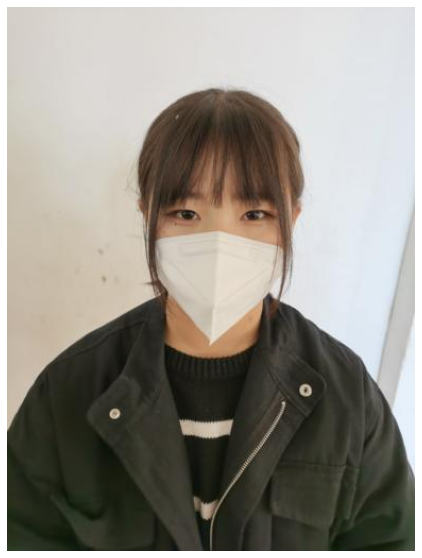

In [62]:
from matplotlib import pyplot as plt
import cv2
img = cv2.imread(train_dir + '/003397_female_Asian_19/mask1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')



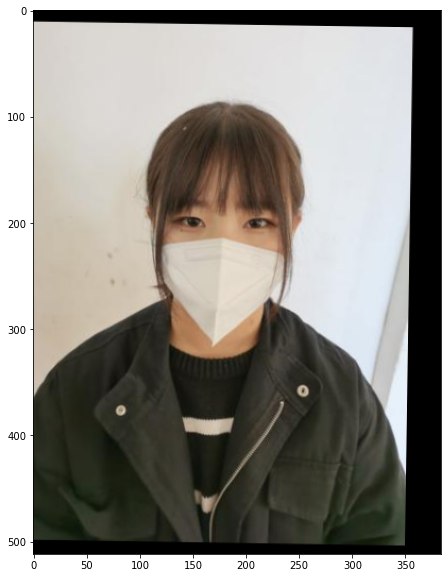

In [107]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(transformation(image=img)['image'])

In [55]:
file_feature = ['mask', 'incorrect_mask', 'normal']

def get_train_img_path(train_dir, img_path, feature=None):
    """
    Generate real path for img_path and featured.
    Return without extension. (jpg, png ...)
    """
    if feature is None:
        """
        Generate all path for img_path
        """
        path = []
        for feature in file_feature:
            result = get_train_img_path(train_dir, img_path, feature)
            if isinstance(result, list):
                path.extend(result)
            else:
                path.append(result)
    elif feature == 'mask':
        path = [os.path.join(train_dir, f'{img_path}/{feature}{i}') for i in range(1, 6)]
    else:
        path = os.path.join(train_dir, f'{img_path}/{feature}')
    return path
        
def get_test_img_path():
    """Return with extension. (jpg, png, ...) """
    return [os.path.join(train_dir, image_id) for image_id in test_pd['ImageID']]

get_train_img_path(train_dir, '000004_male_Asian_54', 'incorrect_mask')
# get_test_img_path()
# glob.glob('/opt/ml/input/data/train/images/000004_male_Asian_54/mask1' + '*')

'/opt/ml/input/data/train/images/000004_male_Asian_54/incorrect_mask'

In [112]:
class DataFrameModule:
    """
    Manage dataframe for mask database.
    """
    def __init__(self, data_df, images_dir):
        self.data_df = data_df
        print(self.data_df.size)
        self.images_dir = images_dir
        self.system_path_column = 'system_path'

    def get_df_with_path(self, feature=None, train=True) -> pd.DataFrame:
        """
        Generate dataframe for given parmaeters and return.
            feature:
                If featuer is None, get all features.
        """
        new_column = list(self.data_df.columns) + [self.system_path_column]
        new_df = pd.DataFrame(columns=new_column)
        count = 0
        for idx in range(self.data_df.shape[0]):
            # Generate all real path with given featuer
            for path in self.get_path(idx, feature):
                new_df.loc[count] = list(self.data_df.loc[idx]) + path
                count += 1
        return new_df

    def get_path(self, idx, feature) -> list:
        # merge path and feature
        base_path = self.data_df.iloc[idx, -1]

        # Get all possilbe path for base_path and feature
        target_path = get_train_img_path(self.images_dir, base_path, feature)

        # Append asterisk for using glob, cause all the images have different extension.
        if isinstance(target_path, list):
            target_path = [p + '*' for p in target_path]
            target_path = [glob.glob(p) for p in target_path]
        elif isinstance(target_path, str):
            target_path = target_path + '*'
            target_path = glob.glob(target_path)
        return target_path

train_df_manager = DataFrameModule(train_pd, train_dir)
with_path = train_df_manager.get_df_with_path()







13500


In [113]:
with_path.to_csv('./with_path.csv')

In [6]:
class MaskDataset(Dataset):
    def __init__(self, data_df, images_dir, transforms, feature=None, train=True):    
        self.data_df = data_df
        self.images_dir = images_dir
        self.classes = range(18)
        self.transforms = transforms
        self.train = traind
        self.feature = feature

        if not train:
            self.test_path_list = get_test_img_path()
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if train:
            # merge path and feature
            base_path = self.data_df.loc[idx, 'path']

            # Get all possilbe path for base_path and feature
            target_path = get_train_img_path(self.images_dir, base_path, self.feature)

            # Append asterisk for using glob, cause all the images have different extension.
            if isinstance(target_path, list):
                target_path = [target_path + '*' for p in target_path]
            elif isinstance(target_path, str):
                target_path = target_path + '*'
            target_path = glob.glob(target_path)
        else:
            target_path = self.test_path_list[idx]

        img = Image.open(target_path)

        if self.train:
            label = get_label(path)
        else:
            label = get_test_label(path)

        if self.transforms:
            img = self.transforms(img)
            
        return img, label

In [18]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize(224)
    ])
train_dataset = MaskDataset(train_dir_glob, transformation)
test_dataset = MaskDataset(test_dir_glob, transformation, train=False)

In [19]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)
img, labels = next(iter(train_dataloader))
# img, labels = next(iter(test_dataloader))
# print(img)
# print(labels)

In [93]:
from sklearn.model_selection import KFold

In [20]:
# Size of X
print(f'Length of X = {len(train_dataset)}')

# Size of image on X
print(f'Original size of image on X = {img.shape}')

Length of X = 18900
Size of image on X = torch.Size([16, 3, 512, 384])


In [9]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0')
import torchvision
# imagenet_resnet18 = torchvision.models.resnet50(pretrained=True)
model = torchvision.models.resnet18(pretrained=True)
print("네트워크 필요 입력 채널 개수", model.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", model.fc.weight.shape[0])
print(model)

네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 1000
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [10]:
MASK_CLASS_NUM = 18
import math
model.fc = torch.nn.Linear(in_features=512, out_features=MASK_CLASS_NUM, bias=True)
torch.nn.init.xavier_uniform_(model.fc.weight)
stdv = 1. / math.sqrt(model.fc.weight.size(1))
model.fc.bias.data.uniform_(-stdv, stdv)

tensor([ 0.0073, -0.0133,  0.0128,  0.0014,  0.0222,  0.0377,  0.0407, -0.0382,
        -0.0007,  0.0414, -0.0204, -0.0183,  0.0437,  0.0033,  0.0055, -0.0004,
        -0.0257, -0.0131])

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 학습 때 GPU 사용여부 결정. Colab에서는 "런타임"->"런타임 유형 변경"에서 "GPU"를 선택할 수 있음

print(f"{device} is using!")
model.to(device) # Resnent 18 네트워크의 Tensor들을 GPU에 올릴지 Memory에 올릴지 결정함

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

dataloaders = {
    "train" : train_dataloader,
    "test" : test_dataloader
}

cuda:0 is using!


In [12]:
### 학습 코드 시작
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
  for phase in ["train", "test"]:
    running_loss = 0.
    running_acc = 0.
    if phase == "train":
      model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
    elif phase == "test":
      model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

    with tqdm(dataloaders[phase], unit="batch") as tepoch:
        for ind, (images, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            # (참고.해보기) 현재 tqdm으로 출력되는 것이 단순히 진행 상황 뿐인데 현재 epoch, running_loss와 running_acc을 출력하려면 어떻게 할 수 있는지 tqdm 문서를 보고 해봅시다!
            # hint - with, pbar
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                logits = model(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                loss = loss_fn(logits, labels)

                if phase == "train":
                  loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                  optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            iter_correct = torch.sum(preds == labels.data)
            running_acc += iter_correct # 한 Batch에서의 Accuracy 값 저장

            tepoch.set_postfix(loss=loss.item(), accuracy=iter_correct.item() / batch_size)

    # 한 epoch이 모두 종료되었을 때,
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
    if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
      best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
      best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")


현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.383, 평균 Accuracy : 0.879



현재 epoch-0의 test-데이터 셋에서 평균 Loss : 8.195, 평균 Accuracy : 0.181



현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.095, 평균 Accuracy : 0.970



현재 epoch-1의 test-데이터 셋에서 평균 Loss : 9.356, 평균 Accuracy : 0.183



현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.058, 평균 Accuracy : 0.980



현재 epoch-2의 test-데이터 셋에서 평균 Loss : 11.032, 평균 Accuracy : 0.180


KeyboardInterrupt: 